# Face mask analysis: classificazione di volti con mascherina e senza
Il notebook sarà suddiviso nelle seguenti sezioni:
1. Caricamento del dataset di Training e Testing e normalizzazione dati
2. Riduzione delle features tramite PCA
3. Classificazione dei dati ridotti con PCA:
    * KNN
    * Expectation Maximization
    * Mean Shift
4. Riduzione delle features tramite LDA
5. Classificazione dei dati ridotti con LDA:
    * Maximum Likelihood
    * KNN

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import norm

Definisco subito la funzione che stampa le statistiche di classficazione fornite dalla confusion matrix

In [2]:
def results_info(confusion_matrix):
    assert(confusion_matrix.shape == (2,2))
    print("Matrice di confusione:")
    print(confusion_matrix)

    print(f"Precisione no mask: {confusion_matrix[0,0] / np.sum(confusion_matrix[0,:]) : .2f}")
    print(f"Precisione yes mask: {confusion_matrix[1,1] / np.sum(confusion_matrix[1,:]) : .2f}")
    print(f"Recall no mask: {confusion_matrix[0,0] / np.sum(confusion_matrix[:,0]) : .2f}")
    print(f"Recall yes mask: {confusion_matrix[1,1] / np.sum(confusion_matrix[:,1]) : .2f}")
    print(f"Accuracy: {np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix) : .2f}")

Definisco le variabili globali ed elenco le sottodirectory

In [3]:
root_path = "Face_Mask_Dataset"

subdirs = os.listdir(root_path)
im_shape = (100,100)

print("Sottocartelle:")
print(subdirs)

del subdirs

Sottocartelle:
['Test', 'Train']


La funzione seguente serve per contare il numero di file (devono esserci solo immagini) nella cartella indicata da *dirpath* e tutte le sottocartelle

## Caricamento immagini e corrispondenti labels
I dati di ogni partizione del dataset vengono caricati in 2 array:
* uno **n_features x n_campioni** per le immagini (un campione per colonna)
* uno **n_campioni** le labels delle immagini nella forma

### Immagini
* Tutte le immagini sono ridimensionate alla dimensione *image_shape* per renderle uniformi
* Tutte i pixel vengono convertiti in scala di grigi \[0..1\] *float32* effettuando fin da subito una riduzione di dimensionalità per questioni di performance e per rendere la classificazione indipendente dal colore.

### Labels
* 0: immagine senza mascherina
* 1: immagine con mascherina

In [4]:
def image_counter(dirpath):
    n_images = 0
    for _, _, filenames in os.walk(root_path + os.path.sep + dirpath):
        n_images += len(filenames)
    return n_images

In [5]:
def image_loader(dirpath, image_shape):
    n_images = image_counter(dirpath)
    
    samples_vector = np.zeros((image_shape[0] * image_shape[1], n_images), dtype="float32")
    labels_vector = np.zeros(n_images, dtype="uint8")
    
    column_index = 0

    for subdirpath, _, filenames in os.walk(root_path + os.path.sep + dirpath):
        label_string = subdirpath.split(sep=os.path.sep)[-1]

        label = (1 if label_string == "WithMask" else 0)

        for file in filenames:
            im = Image.open(subdirpath + os.path.sep + file)
            # grey scale 8-bit [0..255]
            im = im.resize(im_shape).convert('L')

            # convert to column vactor and 0..1
            sample = (np.array(im).reshape(-1) / 255.0).astype("float32")
            im.close()

            samples_vector[:, column_index] += sample
            labels_vector[column_index] += label

            column_index += 1
    
    return samples_vector, labels_vector

Caricamento dei dataset di training

In [6]:
train_samples, train_labels = image_loader("Train", im_shape)

Normalizzazione dei samples sottraendo la media da ciascuno di essi

In [7]:
def samples_normalizer(samples_vector):
    mean_vector = np.mean(samples_vector, axis=1, keepdims=True).astype("float32")
    return samples_vector - mean_vector

In [8]:
normalized_train_samples = samples_normalizer(train_samples)

Verifico che il contenuto semantico non venga perso con la sottrazione della media

<Figure size 432x288 with 0 Axes>

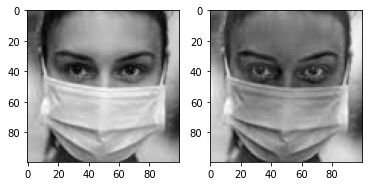

In [9]:
plt.set_cmap("gray")
fig, axes = plt.subplots(1,2)

axes[0].imshow(train_samples[:,1].reshape(im_shape))
axes[1].imshow(normalized_train_samples[:,1].reshape(im_shape))

In [10]:
del axes
del fig

## Principal Component Analysis
* Creo una una matrice di pseudo_scatter **n_immagini x n_immagini**
* estraggo autovalori (**n_immagini**) e autovettori (**n_immagini x n_immagini**)
* ordino gli autovalori e autovettori in ordine decrescente (argsort + slice inverso)
* ottengo gli autovettori corretti  (**n_features x n_immagini**)
* normalizzo gli autovettori

In [11]:
pseudo_scatter_matrix = normalized_train_samples.T @ normalized_train_samples

lambdas, eigenvecs = np.linalg.eig(pseudo_scatter_matrix)
indexes = lambdas.argsort()[::-1]  
del pseudo_scatter_matrix

# sorting
lambdas = lambdas[indexes].astype("float32")
eigenvecs = eigenvecs[:,indexes].astype("float32")

#true eigenvectors features x n_samples 
eigenvecs = (normalized_train_samples @ eigenvecs)
norms = np.linalg.norm(eigenvecs, axis=0, keepdims=True)
eigenvecs /= norms

del norms
del indexes

<ipython-input-11-c1cda5a7efc3>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  lambdas = lambdas[indexes].astype("float32")
<ipython-input-11-c1cda5a7efc3>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvecs = eigenvecs[:,indexes].astype("float32")


Verifico visivamente la quantità varianza coperta all' aumentare della somma cumulata degli autovalori

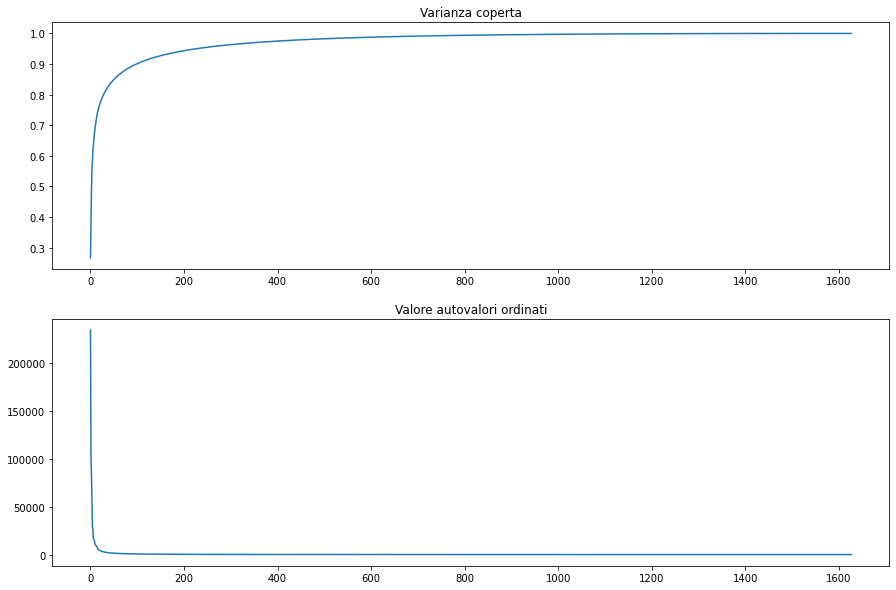

In [12]:
lambdas_energy = np.cumsum(lambdas) / np.sum(lambdas)

fig, axes = plt.subplots(2,1, figsize=(15,10))
x = np.arange(lambdas.size)
axes[0].plot(x,lambdas_energy)
axes[0].set_title("Varianza coperta")

axes[1].plot(x,lambdas)
axes[1].set_title("Valore autovalori ordinati")

del lambdas_energy

In [13]:
del fig
del axes

* Con i primi 300 autovettori copro più del 90% della varianza
* Proietto le immagini di training su questi 300 autovettori **n_components x n_samples**

In [14]:
n_components = 300
projected_train_samples = eigenvecs[:,:n_components].T @ normalized_train_samples

In [15]:
projected_train_samples.shape

(300, 1628)

Verifico visivamente il contenuto semantico delle eigenfaces

<Figure size 432x288 with 0 Axes>

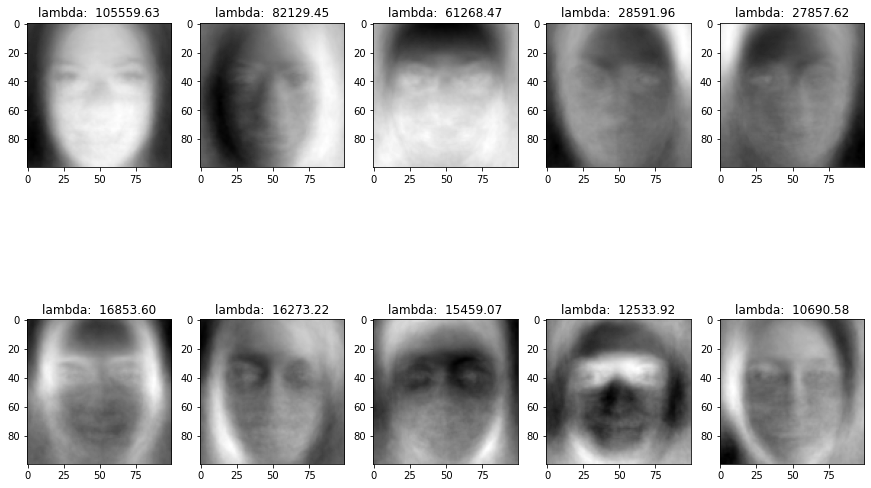

In [16]:
plt.set_cmap("gray")
plt.figure(figsize=(15,10))

for i in range(1,11):
    plt.subplot(2,5,i)
    plt.title(f"lambda: {lambdas[i]: .2f}")
    plt.imshow(eigenvecs[:,i].reshape(im_shape))
    
del lambdas

La eigenfaces più rappresentativa è proprio quella che delinea la forma piena di una faccia, mentre molte altre
danno più enfasi ai dettagli come i bordi.
La terza ha valori vicini a 1 nella zona dove solitamente si trova la mascherina, mentre ultima e penultima delineano
le facce che indossano occhiali

Verifico su un grafico 3D la disposizione spaziale delle immagini proiettate sui primi 3 autovettori

In [17]:
rotations = [(45, 45), (0,90), (90,0), (0,0), (180, 0), (0, 180)]

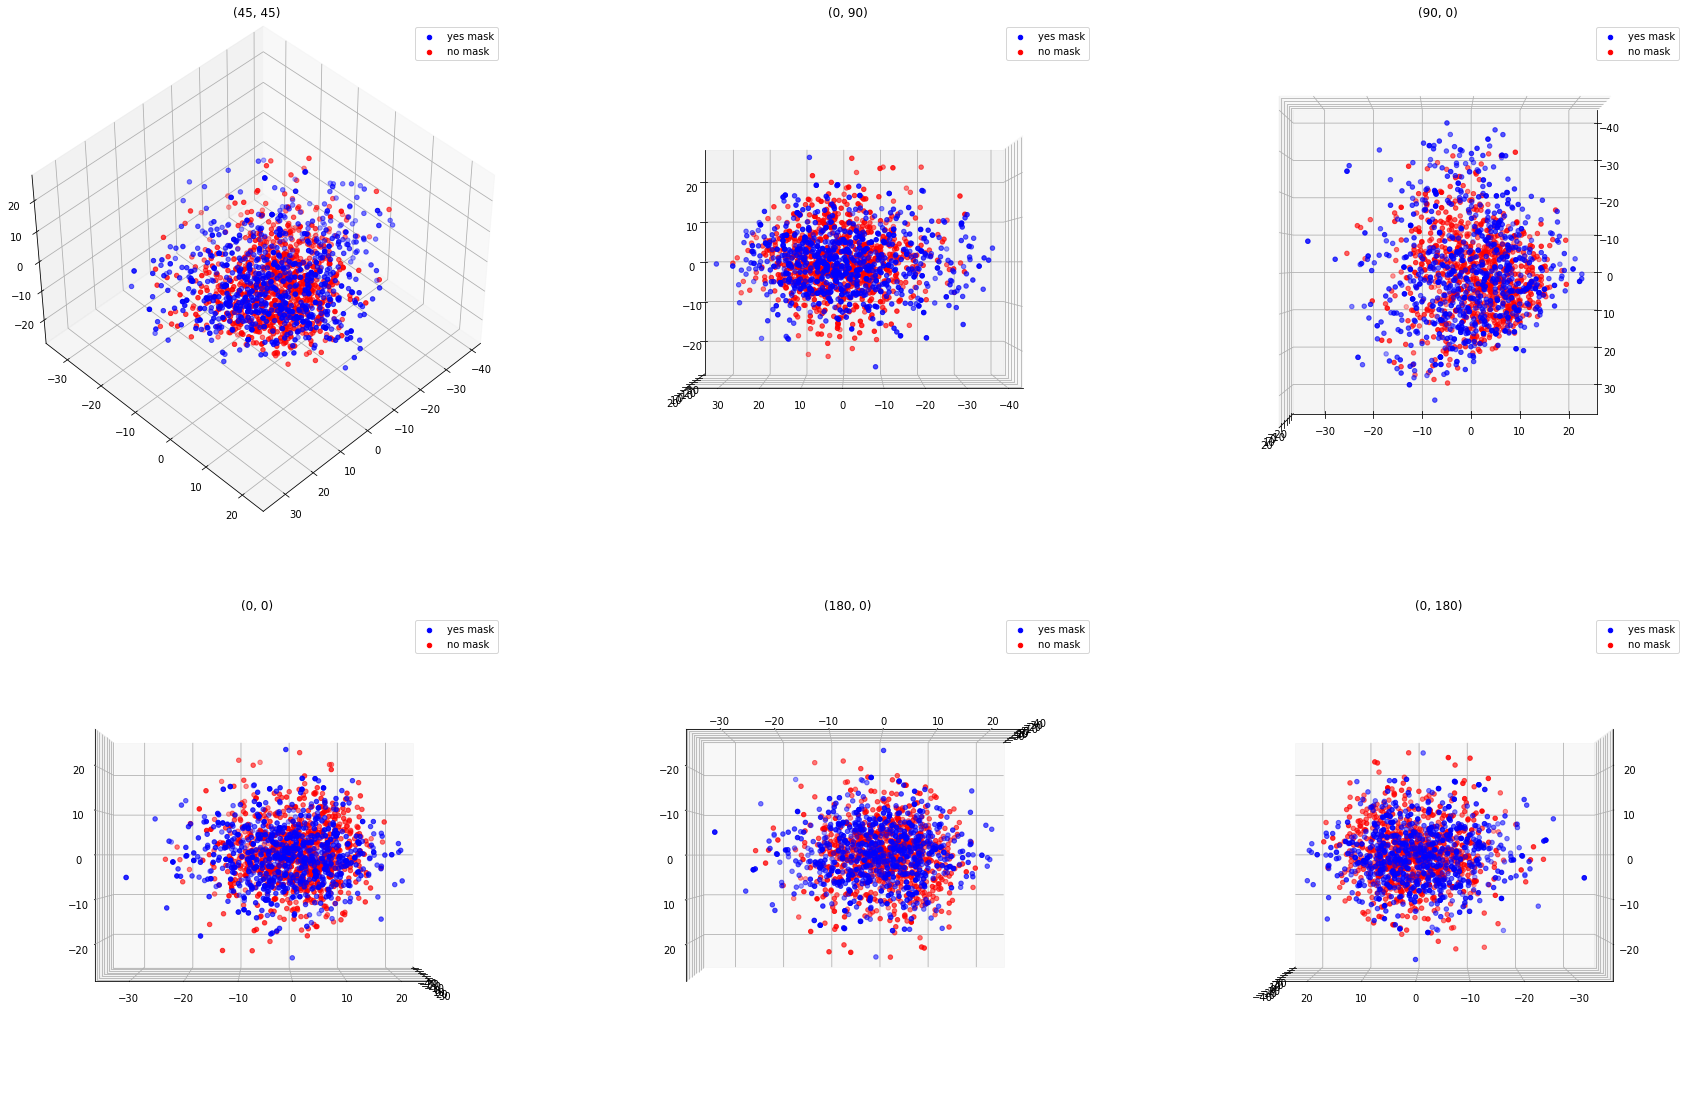

In [18]:
fig = plt.figure(figsize=(30,20))

for i in range(len(rotations)):
    ax = plt.subplot(2,3,i+1, projection='3d')
    
    ax.scatter(*projected_train_samples[:3, train_labels == 1], label='yes mask', c='blue')
    ax.scatter(*projected_train_samples[:3, train_labels == 0], label='no mask', c='red')
    ax.legend()

    ax.view_init(*rotations[i])
    ax.set_title(str(rotations[i]))

Usando i primi 3 autovettori, i dati sembrano essere disposti in due distribuzioni sovrapposte.
Provo a usare degli auovettori diversi (3,5,8).

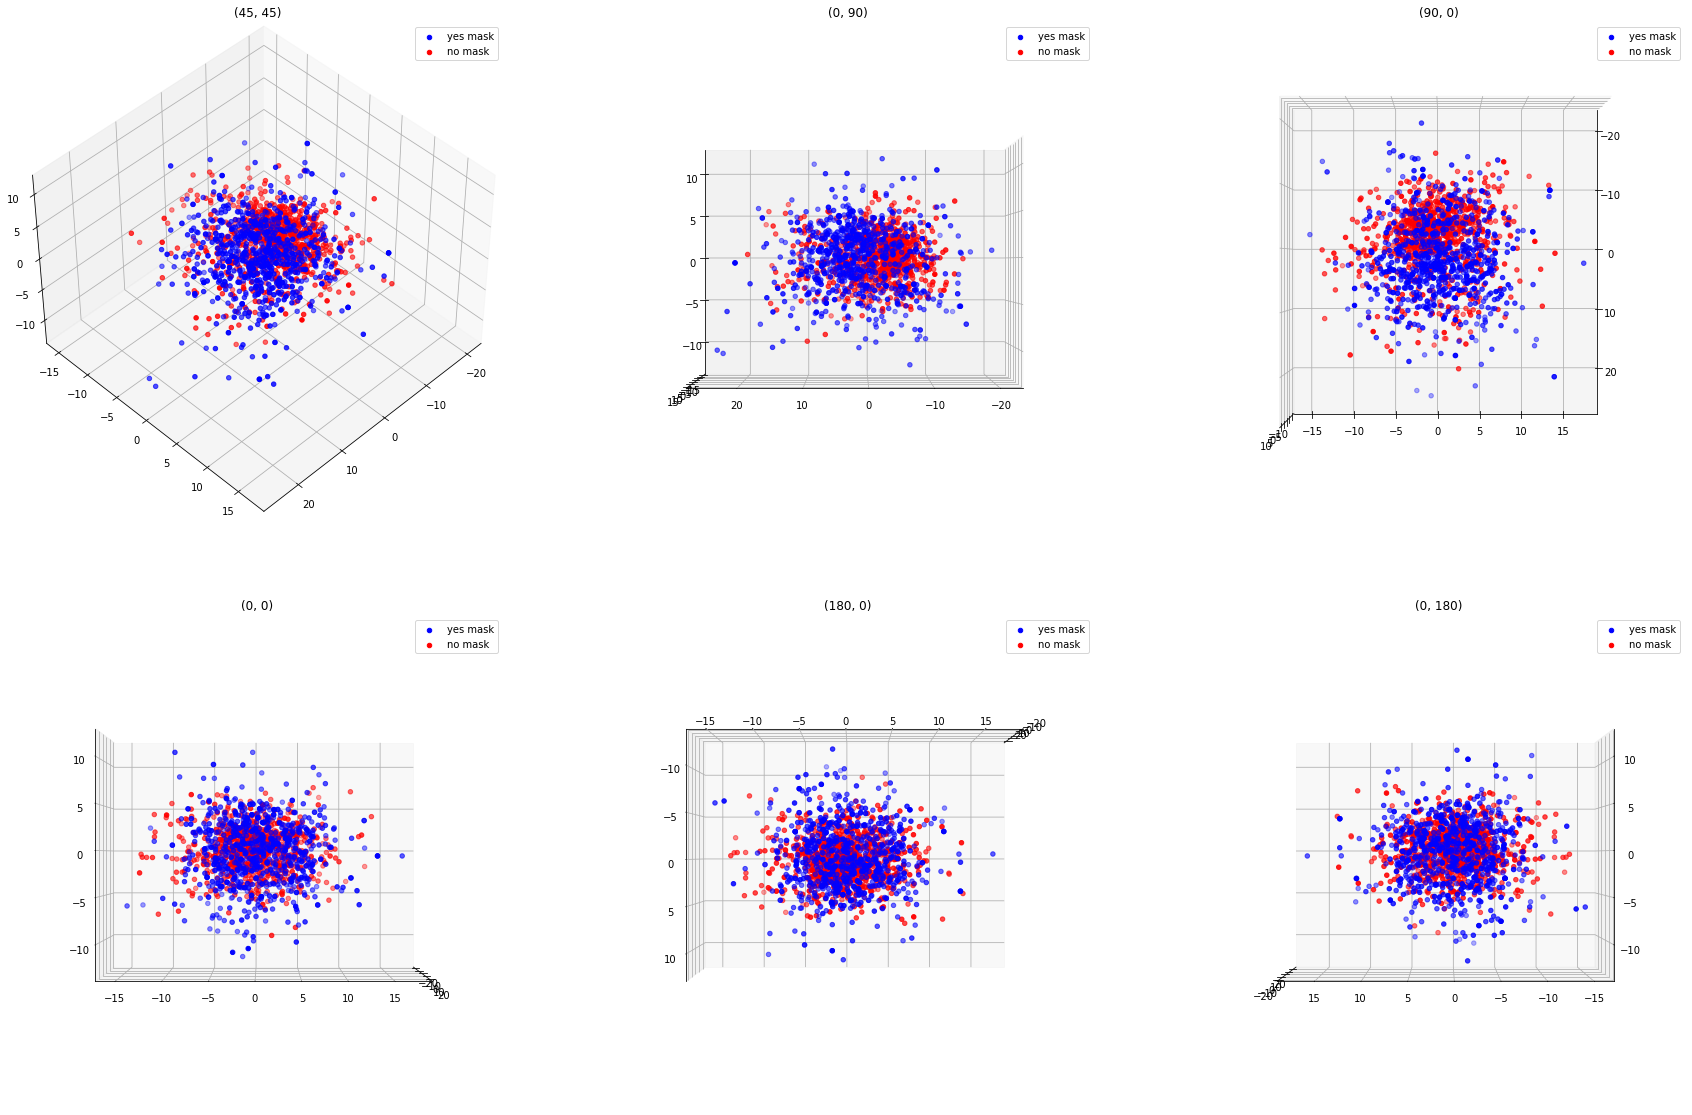

In [19]:
fig = plt.figure(figsize=(30,20))

for i in range(len(rotations)):
    ax = plt.subplot(2,3,i+1, projection='3d')
    indexes = [3,5,8]
    
    ax.scatter(*projected_train_samples[indexes,:][:,train_labels == 1], label='yes mask', c='blue')
    ax.scatter(*projected_train_samples[indexes,:][:,train_labels == 0], label='no mask', c='red')
    ax.legend()

    ax.view_init(*rotations[i])
    ax.set_title(str(rotations[i]))

In [20]:
del fig
del rotations

Già utilizzando degli autovettori differenti, si può notare una separazione tra classi con la rotazione di 90° di elevazione

* Proietto i campioni (immagini) di training *normalizzati* su tutti gli autovettori selezionati (**n_components**).
* Creo la matrice delle distanze dove ogni coefficiente a(i,j) indica la distanza euclidea dell' i-esimo campione dal j-esimo
* salvo nella variabile *treshold* la distanza massima

<Figure size 432x288 with 0 Axes>

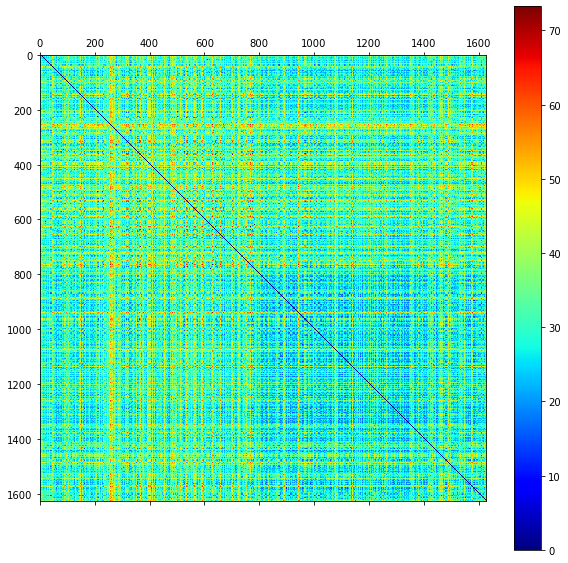

In [21]:
# projected_train_samples = n_components x n_train_samples
projected_train_samples = eigenvecs[:,:n_components].T @ normalized_train_samples
dm = distance_matrix(projected_train_samples.T, projected_train_samples.T)
del normalized_train_samples

plt.set_cmap("jet")
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

im = ax.matshow(dm)
fig.colorbar(im)

treshold = dm.max()

In [22]:
del fig
del ax

Certe righe (o corrispondenti colonne) sono prevalentemente gialle/rosse, probabilmente sono colonne di outliers (la distanza dalle altre immagini è elevata).

Carico le immagini di test e le rispettive labels

In [23]:
test_samples, test_labels = image_loader("Test", im_shape)

In [24]:
test_labels.size

992

* Normalizzo le immagini di test (sottrazione della media)
* Proietto le immagini di test normalizzate sull' autospazio
* Calcolo la matrice delle distanze tra le immagini di test e quelle di training e la visualizzo

<Figure size 432x288 with 0 Axes>

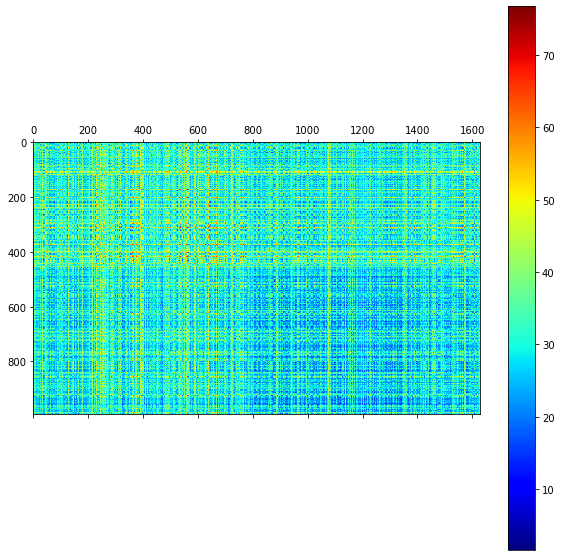

In [25]:
# projected_test_samples = n_components x n_test_samples
test_samples_mean = test_samples.mean(axis=1, keepdims=True)
projected_test_samples = eigenvecs[:,:n_components].T @ samples_normalizer(test_samples)

dm = distance_matrix(projected_test_samples.T, projected_train_samples.T)

plt.set_cmap("jet")
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

im = ax.matshow(dm)
fig.colorbar(im)

In [26]:
del im

Questa matrice verrà utilizzata per trovare il campione di training più vicino per ogni campione di testing

## Classificazione: KNN
1. Ricostruisco le immagini di test come sommatoria **<component,projection>**
2. Calcolo la matrice *reconstruction_error* dove ogni coefficiente indica l' errore di ricostruzione per lo stesso indice
3. Uso la *distance matrix* per scegliere i k campioni di training più vicini 
4. Scelgo la classe più frequente tra i vicini al campione di testing come *classe predetta* per il campione di testing

In [27]:
reconstructed_test_samples = (eigenvecs[:,:n_components] @ projected_test_samples) + test_samples_mean

reconstruction_error = np.linalg.norm(test_samples - reconstructed_test_samples, axis=0)

for k in range(1,5+1):
    print(f"K = {k}")
    confusion_matrix = np.zeros((2,2))
    not_recognizable_count = 0

    for i in range(reconstruction_error.size):
        if reconstruction_error[i] < treshold and np.max(dm[i,:]) <= treshold:
            no_mask_neighbors = np.count_nonzero(train_labels[np.argsort(dm[i,:])[:k]] == 0)
            yes_mask_neighbors = np.count_nonzero(train_labels[np.argsort(dm[i,:])[:k]] == 1)
            predicted_label = 0 if no_mask_neighbors > yes_mask_neighbors else 1
            
            true_label = test_labels[i]
            confusion_matrix[predicted_label,true_label] += 1
        else:
            not_recognizable_count += 1

    results_info(confusion_matrix)
    print(f"Campioni di testing non riconoscibili: {not_recognizable_count}")
    print()

K = 1
Matrice di confusione:
[[446. 192.]
 [ 63. 289.]]
Precisione no mask:  0.70
Precisione yes mask:  0.82
Recall no mask:  0.88
Recall yes mask:  0.60
Accuracy:  0.74
Campioni di testing non riconoscibili: 2

K = 2
Matrice di confusione:
[[405. 131.]
 [104. 350.]]
Precisione no mask:  0.76
Precisione yes mask:  0.77
Recall no mask:  0.80
Recall yes mask:  0.73
Accuracy:  0.76
Campioni di testing non riconoscibili: 2

K = 3
Matrice di confusione:
[[447. 216.]
 [ 62. 265.]]
Precisione no mask:  0.67
Precisione yes mask:  0.81
Recall no mask:  0.88
Recall yes mask:  0.55
Accuracy:  0.72
Campioni di testing non riconoscibili: 2

K = 4
Matrice di confusione:
[[432. 159.]
 [ 77. 322.]]
Precisione no mask:  0.73
Precisione yes mask:  0.81
Recall no mask:  0.85
Recall yes mask:  0.67
Accuracy:  0.76
Campioni di testing non riconoscibili: 2

K = 5
Matrice di confusione:
[[454. 215.]
 [ 55. 266.]]
Precisione no mask:  0.68
Precisione yes mask:  0.83
Recall no mask:  0.89
Recall yes mask:  0.5

In [28]:
del confusion_matrix
del dm
del not_recognizable_count
del treshold
del reconstructed_test_samples
del reconstruction_error

I risultati sono buoni, sopratutto con K = 2,4:
* il numero di campioni non classificabili (non riconosciuti come facce) è irrisorio
* ogni statistica è superiore al 50%

## Classificazione: expectation maximization
1. Separo in base alle classi i campioni di training proiettati
2. Cerco di stimare la distribuzione di ogni classe come mistura di gaussiane provando un numero diverso di picchi (mode) per la gaussiana
3. Classifico i campioni di test in base alla posterior probability (*score samples*) maggiore tra le due classi.

In [29]:
no_mask_train_samples = projected_train_samples[:,train_labels == 0]
yes_mask_train_samples = projected_train_samples[:,train_labels == 1]

from sklearn.mixture import GaussianMixture

no_mask_distributions = list()
yes_mask_distributions = list()
n_modes_list = list()

max_modes = 5
for i in range(8):
    n_modes = i+1
    no_mask_distributions.append(GaussianMixture(n_components=n_modes).fit(no_mask_train_samples.T))
    yes_mask_distributions.append(GaussianMixture(n_components=n_modes).fit(yes_mask_train_samples.T))
    n_modes_list.append(n_modes)

distributions = list(zip(yes_mask_distributions, no_mask_distributions, n_modes_list))

del no_mask_distributions
del yes_mask_distributions

for d in distributions:
    confusion_matrix = np.zeros((2,2))
    predictions = d[0].score_samples(projected_test_samples.T) - d[1].score_samples(projected_test_samples.T)

    predictions[predictions > 0] = 1
    predictions[predictions <= 0] = 0
    predictions = predictions.astype("uint8")
    
    for i in range(predictions.size):
        confusion_matrix[predictions[i], test_labels[i]] += 1
        
    print(f"Results with {d[2]} components:")
    results_info(confusion_matrix)
    print()
    
del distributions

Results with 1 components:
Matrice di confusione:
[[463.  43.]
 [ 46. 440.]]
Precisione no mask:  0.92
Precisione yes mask:  0.91
Recall no mask:  0.91
Recall yes mask:  0.91
Accuracy:  0.91

Results with 2 components:
Matrice di confusione:
[[377.  20.]
 [132. 463.]]
Precisione no mask:  0.95
Precisione yes mask:  0.78
Recall no mask:  0.74
Recall yes mask:  0.96
Accuracy:  0.85

Results with 3 components:
Matrice di confusione:
[[509. 470.]
 [  0.  13.]]
Precisione no mask:  0.52
Precisione yes mask:  1.00
Recall no mask:  1.00
Recall yes mask:  0.03
Accuracy:  0.53

Results with 4 components:
Matrice di confusione:
[[507. 423.]
 [  2.  60.]]
Precisione no mask:  0.55
Precisione yes mask:  0.97
Recall no mask:  1.00
Recall yes mask:  0.12
Accuracy:  0.57

Results with 5 components:
Matrice di confusione:
[[303.  17.]
 [206. 466.]]
Precisione no mask:  0.95
Precisione yes mask:  0.69
Recall no mask:  0.60
Recall yes mask:  0.96
Accuracy:  0.78

Results with 6 components:
Matrice di co

In [30]:
del max_modes
del yes_mask_train_samples
del no_mask_train_samples

I risultati migliori si ottengono stimando le distribuzioni con 1 o 2 gaussiane, invece con più gaussiane (tranne 4 e 7) si ottengono dei risultati di classificazione spostati verso la classe 0 *no_mask*, ottenendo molti falsi positivi.

## Classificazione: Mean Shift
1. Si divide il dataset di training nelle 2 classi
2. La larghezza della finestra per ogni classe viene stimata con *sklearn.cluster.estimate_bandwidth*
3. Seleziono la larghezza della finestra maggiore e la utilizzo per la stima non parametrica di entrambe le classi
4. Con *sklearn.cluster.meanshift* trovo i cluster della distribuzione sottostante di ciascuna classe
5. Classificazione di un campione x di testing:
    1. Calcolo la distanza di x dal centro di ogni cluster di una determinata classe
    2. Calcolo il quantitativo di campioni di training che ingloba ogni cluster (**peso**)
    3. Calcolo la likelihood di x rispetto a una determinata classe come la somma del peso di ogni cluster diviso per la distanza del campione da quel cluster
    4. scelgo la classe con la likelihood più alta

Dato un centro e il raggio dell' ipersfera, *count_samples* conta il numero di campioni all' interno di quell' ipersfera

In [31]:
def count_samples(center, bandwidth, samples):
    center = center.reshape(-1,1)
    samples = samples[:,np.linalg.norm(samples - center, axis = 0) <= bandwidth]
    return samples.shape[1]

* *compute_score* calcola la likelihood per un sample x di appartenere ad una determinata classe definita da un insieme di clusters.
* Questi clusters sono ipersfere descritte dai centri (*cluster_centers*) e i sample che si trovano dentro il loro raggio (*bandwidth*)

In [32]:
def compute_score(x, cluster_centers, bandwidth, samples):
    # distances
    x = x.reshape(-1,1)
    scores = np.linalg.norm(cluster_centers - x, axis = 0)
    
    # divide by distances
    for i in range(cluster_centers.shape[1]):
        scores[i] = count_samples(cluster_centers[:,i], bandwidth, samples) / scores[i]
    
    return scores.sum()

In [33]:
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

projected_no_mask = projected_train_samples[:, train_labels == 0]
projected_yes_mask = projected_train_samples[:, train_labels == 1]

window_bandwidth = max(estimate_bandwidth(projected_no_mask.T),
                estimate_bandwidth(projected_yes_mask.T))

no_mask_clusters = MeanShift(bandwidth=window_bandwidth).fit(projected_no_mask.T).cluster_centers_.T
yes_mask_clusters = MeanShift(bandwidth=window_bandwidth).fit(projected_yes_mask.T).cluster_centers_.T

predictions = np.zeros(test_labels.size)

for i in range(projected_test_samples.shape[1]):
    x = projected_test_samples[:,i]
    no_mask_score = compute_score(x, no_mask_clusters, window_bandwidth, projected_test_samples)
    yes_mask_score = compute_score(x, yes_mask_clusters, window_bandwidth, projected_test_samples)
    
    predictions[i] += yes_mask_score - no_mask_score
    
predictions[predictions > 0] = 1
predictions[predictions <= 0] = 0
predictions = predictions.astype("uint8")

In [34]:
confusion_matrix = np.zeros((2,2))

for i in range(test_labels.size):
    confusion_matrix[predictions[i], test_labels[i]] += 1
    
results_info(confusion_matrix)

Matrice di confusione:
[[339. 178.]
 [170. 305.]]
Precisione no mask:  0.66
Precisione yes mask:  0.64
Recall no mask:  0.67
Recall yes mask:  0.63
Accuracy:  0.65


In [35]:
del eigenvecs
del yes_mask_clusters
del no_mask_clusters
del no_mask_score
del yes_mask_score
del predictions

I risultati non sono pessimi, ma non al livello di quelli ottenuti con EM

## Linear Discriminant Analysis
* Proietto tutti i dati su di un unico asse che massimizza le distanze tra classi (distanze tra medie) e minimizza la varianza di ciascuna classe.

In [36]:
train_samples, train_labels = image_loader("Train", im_shape)
test_samples, test_labels = image_loader("Test", im_shape)

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(train_samples.T, train_labels)
LinearDiscriminantAnalysis()

transformed_samples = clf.transform(train_samples.T)

Verifico graficamente la disposizione dei dati

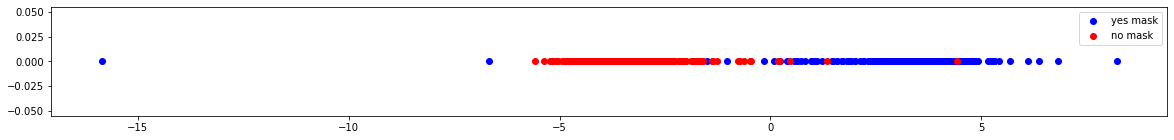

In [38]:
fig = plt.figure(figsize=(20,2))
ax = plt.subplot()

transformed_yes_samples = np.squeeze(transformed_samples[train_labels == 1])
transformed_no_samples = np.squeeze(transformed_samples[train_labels == 0])

ax.scatter(transformed_yes_samples, np.zeros(transformed_yes_samples.size), label='yes mask', c='blue')
ax.scatter(transformed_no_samples, np.zeros(transformed_no_samples.size), label='no mask', c='red')
ax.legend()

Si possono notare degli outliers sia per quanto riguarda le immagini *yes_mask* che quelle *no_mask* rispettivamente con valore < -5 e > 2.5.
Li visualizzo

<Figure size 432x288 with 0 Axes>

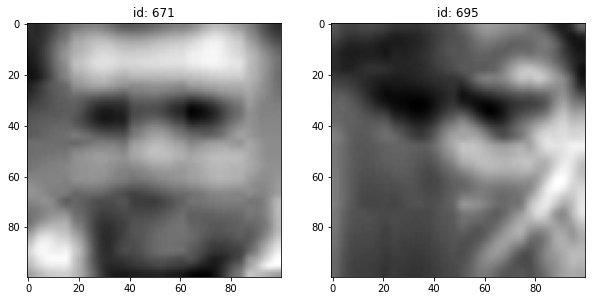

In [39]:
fake_no_mask = np.nonzero((train_labels == 1) * np.squeeze(transformed_samples <= -5))[0]
plt.set_cmap("gray")

plt.figure(figsize=(10,5))
for i in range(1, fake_no_mask.size+1):
    im_index = fake_no_mask[i-1]
    
    plt.subplot(1,fake_no_mask.size,i)
    plt.title(f"id: {im_index}")
    plt.imshow(train_samples[:,im_index].reshape(im_shape))

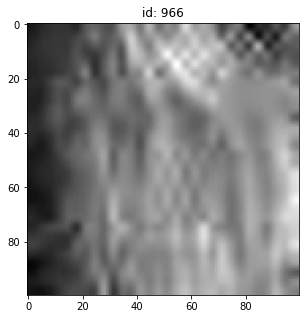

In [40]:
fake_yes_mask = np.nonzero((train_labels == 0) * np.squeeze(transformed_samples >= 2.5))[0]

plt.figure(figsize=(10,5))
for i in range(1, fake_yes_mask.size+1):
    im_index = fake_yes_mask[i-1]
    
    plt.subplot(1,fake_yes_mask.size,i)
    plt.title(f"id: {im_index}")
    plt.imshow(train_samples[:,im_index].reshape(im_shape))

Gli outliers rappresentano immagini un ambigue, anche per l' occhio umano

## Classificazione: Maximum Likelihood gaussiana
1. Calcolo media e varianza delle due classi la cui distribuzione è considerata normale
2. Seleziono la classe con la probabilità più elevata

In [41]:
transformed_yes_mask = np.squeeze(transformed_samples[np.nonzero(train_labels == 1)])
transformed_no_mask = np.squeeze(transformed_samples[np.nonzero(train_labels == 0)])

yes_mask_mean = np.mean(transformed_yes_mask)
no_mask_mean = np.mean(transformed_no_mask)

yes_mask_std = np.std(transformed_yes_mask)
no_mask_std = np.std(transformed_no_mask)

print(f"yes mask mean: {yes_mask_mean}")
print(f"yes mask std: {yes_mask_std}")
print(f"no mask mean: {no_mask_mean}")
print(f"no mask std: {no_mask_std}")

confusion_matrix = np.zeros((2,2))

for i in range(test_samples.shape[1]):
    sample_projection = clf.transform(test_samples[:,i].reshape(1,-1))
    yes_prob = np.log(norm.pdf(sample_projection, loc=yes_mask_mean, scale=yes_mask_std))
    no_prob = np.log(norm.pdf(sample_projection, loc=no_mask_mean, scale=no_mask_std))
    predicted_class = 0 if no_prob > yes_prob else 1
    
    confusion_matrix[predicted_class, test_labels[i]] += 1
    
results_info(confusion_matrix)

yes mask mean: 3.569758285229937
yes mask std: 1.1707899520760339
no mask mean: -3.569758285229931
no mask std: 0.7917031550150587
Matrice di confusione:
[[360. 188.]
 [149. 295.]]
Precisione no mask:  0.66
Precisione yes mask:  0.66
Recall no mask:  0.71
Recall yes mask:  0.61
Accuracy:  0.66


I risultati non sembrano pessimi, ma probabilmente gli outliers *yes_mask* pesano sul classificatore (spostano la media verso i valori negativi e aumentano la varianza)

## Classificazione: KNN
Vista la distribuzione dei dati, per risolvere il problema degl outliers nella classificazione si potrebbe provare a usare KNN con diversi K.

In [42]:
for k in range(1,10+1):
    print(f"K = {k}")
    confusion_matrix = np.zeros((2,2))

    for i in range(test_samples.shape[1]):
        sample_projection = np.squeeze(clf.transform(test_samples[:,i].reshape(1,-1)))

        distances = np.abs(np.squeeze(transformed_samples) - sample_projection)
        nearest_elements = np.argsort(distances)[:k]

        no_prob = np.count_nonzero(train_labels[nearest_elements] == 0)
        yes_prob = np.count_nonzero(train_labels[nearest_elements] == 1)

        predicted_class = 0 if no_prob > yes_prob else 1
        confusion_matrix[predicted_class, test_labels[i]] += 1

    results_info(confusion_matrix)
    print()

K = 1
Matrice di confusione:
[[253. 125.]
 [256. 358.]]
Precisione no mask:  0.67
Precisione yes mask:  0.58
Recall no mask:  0.50
Recall yes mask:  0.74
Accuracy:  0.62

K = 2
Matrice di confusione:
[[237. 118.]
 [272. 365.]]
Precisione no mask:  0.67
Precisione yes mask:  0.57
Recall no mask:  0.47
Recall yes mask:  0.76
Accuracy:  0.61

K = 3
Matrice di confusione:
[[378. 189.]
 [131. 294.]]
Precisione no mask:  0.67
Precisione yes mask:  0.69
Recall no mask:  0.74
Recall yes mask:  0.61
Accuracy:  0.68

K = 4
Matrice di confusione:
[[361. 179.]
 [148. 304.]]
Precisione no mask:  0.67
Precisione yes mask:  0.67
Recall no mask:  0.71
Recall yes mask:  0.63
Accuracy:  0.67

K = 5
Matrice di confusione:
[[388. 208.]
 [121. 275.]]
Precisione no mask:  0.65
Precisione yes mask:  0.69
Recall no mask:  0.76
Recall yes mask:  0.57
Accuracy:  0.67

K = 6
Matrice di confusione:
[[386. 202.]
 [123. 281.]]
Precisione no mask:  0.66
Precisione yes mask:  0.70
Recall no mask:  0.76
Recall yes mas

Sembra che con K = 4 si ottenga il risultato migliore, anche se l' algoritmo non ha mai prestazioni pessime neanche con K diversi da 4